In [2]:
from sklearn.cluster import KMeans
import numpy as np

In [3]:
import heapq

class PriorityQueue:
    """
    A simple priority queue implementation using heapq.
    Stores items with their priorities and allows to push and pop items efficiently.
    Lower priority values come first.
    """
    def __init__(self):
        self.items = []
        self.count = 0  # Tie-breaker for comparisons

    def __bool__(self):
        return bool(self.items)

    def push(self, priority, item):
        heapq.heappush(self.items, (priority, self.count, item))
        self.count += 1

    def pop(self):
        priority, count, item = heapq.heappop(self.items)
        return priority, item

In [4]:
class LimitedSet:
    """
    A limited set implementation to keep the k closest neighbors based on distance.
    Combines a priority queue with a set for uniqueness.
    """
    def __init__(self, k: int):
        self.pq = []  # Priority queue for neighbors
        self.items = set()  # Set to ensure uniqueness
        self.k = k
    def get_max_distance(self):
        """
        Get the maximum distance of the current neighbors.
        If no neighbors are present, return infinity.
        """
        return self.pq[-1][0] if self.pq else float('inf')
    def add(self, distance, value):
        """
        Add a candidate to the set if it's among the k closest.
        """
        if isinstance(value, np.ndarray):
            value = tuple(value)
        if (distance, value) in self.items:
            return  # Ignore duplicates
        
        heapq.heappush(self.pq, (-distance, value))  # Use -distance for max-heap behavior
        self.items.add(value)
        
        if len(self.pq) > self.k:
            # Remove the farthest element
            _, removed_value = heapq.heappop(self.pq)
            self.items.remove(removed_value)

    def get_sorted_neighbors(self):
        """
        Return the neighbors sorted by distance.
        """
        return sorted(((-d, v) for d, v in self.pq), key=lambda x: x[0])
    def __iter__(self):
        """
        Allow iteration over the elements in the priority queue.
        """
        return iter(self.get_sorted_neighbors())
    def discard(self, item) :
        if item in self.items:
            self.items.remove(item)
            # Rebuild the priority queue to maintain consistency
            self.pq = [entry for entry in self.pq if entry[1] != item]
            heapq.heapify(self.pq)  # Re-heapify after removal
    def limit(self):
        """
        Return the highest priority value (lowest value) in the limited set.
        """
        if not self.pq:
            return float('inf')
        while self.pq and self.pq[0][1] not in self.items:
            heapq.heappop(self.pq)
        return float("inf") if len(self.items) < self.k else -self.pq[0][0]


In [5]:
class Node:
    def __init__(self, tree, routing_object=None):
        """
        Initialize the base Node class.

        :param tree: The MTree instance this node belongs to.
        :param routing_object: The routing object of the node (None for root).
        """
        self.tree = tree  # Reference to the M-tree instance
        self.routing_object = routing_object  # The routing object or None for root
        self.covering_radius = 0  # r(Oi), the radius covering the subtree
        self.parent = None  # Reference to the parent node
        self.parent_distance = None  # d(Oi, P(Oi)) - not defined for the root
        self.distance_function = self.tree.distance_function
    
        

    
    def distance(self, item):
        """
        Calculate the distance from this node's routing_object to another node or value.

        :param item: The other node or value to calculate the distance to.
        :return: The calculated distance.
        """
        
        
        if isinstance(item, Node):
           
            return self.distance_function(self.routing_object, item.routing_object) + item.covering_radius
        
        return self.distance_function(self.routing_object, item)

    def min_distance(self, value):
        """
        Calculate the minimum distance from this node to a value.

        :param value: The value to calculate the minimum distance to.
        :return: The calculated minimum distance.
        """
        return max(0, self.distance_function(self.routing_object, value) - self.covering_radius)

    def max_distance(self, value):
        """
        Calculate the maximum distance from this node to a value.

        :param value: The value to calculate the maximum distance to.
        :return: The calculated maximum distance.
        """
        return self.distance_function(self.routing_object, value) + self.covering_radius
    def is_root(self):
        return self.parent == None
class DataNode(Node):
    def __init__(self, tree, value):
        """
        Initialize a data node that stores the feature value.

        :param tree: The MTree instance this data node belongs to.
        :param value: The feature value stored in this data node.
        """
        super().__init__(tree=tree, routing_object=value)
        self.tree = tree
        self.value = value  # The feature value (Oj)
        self.oid = id(value)  # Object identifier (oid(Oj))
        self.parent = None
        self.distance_from_parent = 0  # d(Oj, P(Oj))

    """
    Leaf node of the M-tree. Stores database objects.
    """
    def __repr__(self):
        """
        Represent the leaf node as a string.
        """
        return f"DataNode(enty={self.value})"

    def __iter__(self):
       
       yield self.routing_object

    def __contains__(self, item):
        return item == self.routing_object
    




class InternalNode(Node):
    def __init__(self, tree, children) -> None:
        """
        Initialize the InternalNode class.

        :param tree: The MTree instance this internal node belongs to.
        :param children: A list of child nodes for this internal node.
        """
        super().__init__(tree=tree, routing_object=None)
        self.children = []
        self.capacity = self.tree.node_capacity
        self.set_children(children)
        
        
        

    def __repr__(self):
        return f"<{repr(self.routing_object)}, r={repr(self.covering_radius)}, {repr(self.children)}>"

    def set_children(self, children):
        """
        Set the children of this internal node and calculate the covering radius.

        :param children: A list of child nodes to be set as children of this internal node.
        """
        if not children:
            return
        self.children.clear()
        if isinstance(children,InternalNode):
            self.routing_object = children.routing_object
            self.covering_radius = children.covering_radius
            self.children = children.children
        
        else:
            if self.routing_object is None:
                
                self.routing_object = np.mean([child.routing_object for child in children], axis=0)
               
            
            for child in children:
                self._add_child(child)
           
            self.covering_radius = max(self.distance(child) for child in self.children)

    def add_child(self, child):
        """
        Add a child node to this internal node. If the node exceeds capacity, it will be split.

        :param child: The child node to be added.
        """
       
        if len(self.children) >= self.capacity:
            print('i called split',self, ' parent',self.parent)
            self.split(child)
        else:
            self._add_child(child)

    def _add_child(self, child):
        child.parent = self
        self.children.append(child)
        if self.children:
            self.routing_object = np.mean([child.routing_object for child in self.children], axis=0)
        self.covering_radius = max(self.covering_radius, self.distance(child))

    def insert(self, value):
        """
        Insert a value into this node, possibly triggering a recursive descent and split.

        :param value: The value to be inserted.
        """
        
        if self.is_leaf():
            self.add_child(DataNode(self.tree, value))
        else:
            print('mochkila')
            self.covering_radius= max(self.covering_radius, self.distance(value))
            best_child = min(self.children, key=lambda c: c.min_distance(value))
            best_child.insert(value)
       

    def is_leaf(self):
        return all(isinstance(child, DataNode) for child in self.children)

    def split(self, new_node):
        
        
        partitions1, partitions2 = self.promote_and_partition(new_node)
     
        print('a',partitions1)
        print('b',partitions2)
      
        if len(partitions1) == 1 and isinstance(partitions1[0], InternalNode):
           
            untouched_subtree = partitions1[0]
            self.children = untouched_subtree.children  # Use the children directly
            self.routing_object = untouched_subtree.routing_object
            self.covering_radius = untouched_subtree.covering_radius
        else:
            # If partitions1 contains multiple nodes, rebuild `self`
            self.children = partitions1
            self.routing_object = np.mean([child.routing_object for child in self.children], axis=0)
            self.covering_radius = max(self.distance(child) for child in self.children)
        for child in self.children:
            child.parent = self
        if len(partitions2) == 1 and isinstance(partitions2[0], InternalNode):
            print(partitions2[0])
            new_internal = InternalNode(tree=self.tree, children=partitions2[0])
            
            new_internal.parent = self.parent
        else:
            # If partitions1 contains multiple nodes, rebuild `self`
            new_internal = InternalNode(tree=self.tree, children=partitions2)
            new_internal.routing_object = np.mean([child.routing_object for child in new_internal.children], axis=0)
            new_internal.covering_radius = max(new_internal.distance(child) for child in new_internal.children)
            new_internal.parent = self.parent
        # If partitions1 contains multiple nodes, rebuild `self`
       
        #print('0000',new_internal)
        for child in new_internal.children:
            child.parent = new_internal
        
        if self.parent:
            
            self.parent.add_child(new_internal)
        else:
            
            new_root = InternalNode(tree=self.tree, children=[self, new_internal])
            self.tree.root = new_root
            self.parent = new_root
            new_internal.parent = new_root

    def promote_and_partition(self, node):
        
        
        candidates = self.children + [node]
        

        # Split policy: mRAD (minimizing the sum of radii)
        best_pair = None
        min_sum_radii = float('inf')

        for i, a in enumerate(candidates):
            for b in candidates[i + 1:]:
                a_list, b_list = [], []

                for item in candidates:
                    if item == a or item == b:
                        continue
                    if a.distance(item) < b.distance(item):
                        a_list.append(item)
                    else:
                        b_list.append(item)

                r_a = max(a.distance(child) for child in a_list) if a_list else 0
                r_b = max(b.distance(child) for child in b_list) if b_list else 0

                if r_a + r_b < min_sum_radii:
                    min_sum_radii = r_a + r_b
                    best_pair = (a, b, a_list, b_list)

        a, b, a_list, b_list = best_pair
        
        return [a] + a_list, [b] + b_list
    
    def __iter__(self):
        for node in self.children:
            yield from node

    def __contains__(self, item):
        return any(item in node for node in self.children)

In [6]:
class MTree:
    def __init__(self, values=(), *, node_capacity=2, distance_function=None):
        """
        Initialize the MTree.

        :param values: An iterable of values to be inserted into the MTree.
        :param node_capacity: Capacity of the nodes in the MTree.
        :param distance_function: A function to calculate the distance between two values.
        """
        self.distance_function = distance_function or (lambda a, b: abs(a - b))
        self.node_capacity = node_capacity
        self.length = 0
        self.root = None  # Root will be dynamically created as needed.
        

        for value in values:
            self.insert(value)

    def insert(self, value):
        
        """
        Insert a value into the MTree.

        :param value: The value to be inserted.
        """
        self.length += 1

        if self.root is None:
            self.root = InternalNode(tree=self, children=[DataNode(self, value)])
        else:
            self.root.insert(value)
            if self.root.parent:
                self.root = self.root.parent

    def __len__(self):
        """
        Return the number of elements in the MTree.
        """
        return self.length

    def __contains__(self, item):
        """
        Check if an item is in the MTree.

        :param item: The value to check.
        :return: True if the item is in the MTree, False otherwise.
        """
        if self.root is None:
            return False
        return item in self.root

    def __repr__(self):
        """
        Return a string representation of the MTree.
        """
        return repr(self.root) if self.root else "<empty tree>"

    def __iter__(self):
        """
        Iterate over the values in the MTree.

        :yield: Each value stored in the MTree.
        """
        if self.root:
            yield from self.root

    def build_with_clustering(self, data):
        """
        Build the MTree using divisive clustering.
        :param data: A list of data points to cluster and insert into the tree.
        """
        def divisive_clustering(points, max_capacity):
            """
            Perform divisive clustering on the points to create clusters
            with a maximum capacity of max_capacity.
            :param points: List of data points to cluster.
            :param max_capacity: Maximum number of points per cluster.
            :return: A list of clusters, each cluster containing its points.
            """
            clusters = [points]
            while any(len(cluster) > max_capacity for cluster in clusters):
                new_clusters = []
                for cluster in clusters:
                    if len(cluster) <= max_capacity:
                        new_clusters.append(cluster)
                    else:
                        # Use k-means to split the cluster into 2
                        routing_objects = [
                        point.routing_object if isinstance(point, InternalNode) else point
                        for point in cluster
                        ]
                        kmeans = KMeans(n_clusters=2, random_state=42)
                        labels = kmeans.fit_predict(np.array(routing_objects))
                        cluster1 = [cluster[i] for i in range(len(cluster)) if labels[i] == 0]
                        cluster2 = [cluster[i] for i in range(len(cluster)) if labels[i] == 1]
                        new_clusters.extend([cluster1, cluster2])
                clusters = new_clusters
            return clusters

        def calculate_centroid(cluster):
            """
            Calulate the centroid of a cluster.
            :param cluster: List of points (each point is a tuple or list of coordinates) in the cluster.
            :return: The centroid as a tuple representing the mean in each dimension.
            """
            points = np.array([node for node in cluster])  # Extract values from DataNodes
            return tuple(np.mean(points, axis=0))  # Calculate mean for each dimension


        clusters = divisive_clustering(data, self.node_capacity)
        nodes = []

        for cluster in clusters:
            centroid = calculate_centroid(cluster)
            covering_radius = max(self.distance_function(centroid, point) for point in cluster)
            data_nodes = [DataNode(self, value) for value in cluster]
            print(data_nodes)
            internal_node = InternalNode(tree=self, children=data_nodes)
            internal_node.routing_object = centroid
            internal_node.covering_radius = covering_radius
            nodes.append(internal_node)
            print(internal_node)


        # Combine nodes into a tree structure
        while len(nodes) > 1:
            parent_clusters = divisive_clustering(nodes, self.node_capacity)
            print(parent_clusters,'oo')
            new_nodes = []
            for cluster in parent_clusters:
                if len(cluster) == 1:
                    print('cluster',cluster)
                    parent_node = cluster[0]
                else:
                    centroids = [node.routing_object for node in cluster]
                    centroid = np.mean(np.array(centroids), axis=0)
                    covering_radius = max(
                        self.distance_function(centroid, node.routing_object) + node.covering_radius
                        for node in cluster
                    )
                
                    parent_node = InternalNode(tree=self, children=cluster)
                
                    parent_node.routing_object = centroid
                    parent_node.covering_radius = covering_radius
                new_nodes.append(parent_node)
                #print('parent',parent_node)
            nodes = new_nodes

        self.root = nodes[0]
    def knn(self, query_object, k):
            """
            Find the k nearest neighbors of the given query_object in the MTree.

            :param query_object: The object to query for nearest neighbors.
            :param k: The number of nearest neighbors to find.
            :return: A list of the k nearest neighbors.
            """
            if k <= 0:
                return []

            if self.root is None:
                return []

            # Initialize structures
            nearest_neighbors = LimitedSet(k)  # NN array
            priority_queue = PriorityQueue()

            # Start with the root node
            priority_queue.push(self.root.min_distance(query_object), self.root)

            # Dynamic search radius
            max_distance = float('inf')

            while priority_queue:
                d_min, node = priority_queue.pop()
                nearest_neighbors.discard(node)

                # Prune nodes outside the current search radius
                if d_min > max_distance:
                    continue

                if isinstance(node, InternalNode):
                    # Process children of internal node
                    for child in node.children:
                        if (
                        abs(node.distance(query_object) - node.distance(child.routing_object))
                        - child.covering_radius
                            <= nearest_neighbors.limit()
                        ):
                            if child.min_distance(query_object) <= nearest_neighbors.limit():
                                if isinstance(child, InternalNode):
                                    priority_queue.push(child.min_distance(query_object), child)
                                nearest_neighbors.add(child.max_distance(query_object), child)

                

            return [node[1].value  for node in nearest_neighbors]



In [7]:
from math import sqrt
def euclidean_distance(a, b):
    """
    Calculate the Euclidean distance between two points a and b.
    :param a: Tuple representing the first point.
    :param b: Tuple representing the second point.
    :return: Euclidean distance between a and b.
    """
    return sqrt(sum((a_i - b_i) ** 2 for a_i, b_i in zip(a, b)))

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_mtree_with_matplotlib(tree):
    """
    Visualize the M-Tree structure using matplotlib and networkx.

    :param tree: The MTree instance to visualize.
    """
    def add_node_to_graph(graph, node, parent_id=None, pos=None, x=0, y=0, layer=1):
        """
        Recursively add nodes and edges to the NetworkX graph.

        :param graph: The NetworkX graph instance.
        :param node: The current node to add.
        :param parent_id: The ID of the parent node, if any.
        :param pos: The dictionary to store node positions.
        :param x: The x-coordinate for positioning.
        :param y: The y-coordinate for positioning.
        :param layer: The current depth level in the tree.
        """
        node_id = str(id(node))
        pos[node_id] = (x, y)

        if isinstance(node, InternalNode):
            label = f"Internal\n{node.routing_object}\nr={node.covering_radius:.2f}"
        elif isinstance(node, DataNode):
            label = f"Data\n{node.value}"
        else:
            return
        
        graph.add_node(node_id, label=label)
        if parent_id:
            graph.add_edge(parent_id, node_id)
        
        if isinstance(node, InternalNode):
            # Position children horizontally
            num_children = len(node.children)
            spacing = 2 / (2 ** layer)
            child_x = x - spacing * (num_children - 1) / 2
            for child in node.children:
                add_node_to_graph(graph, child, node_id, pos, child_x, y - 1, layer + 1)
                child_x += spacing

    if not tree.root:
        print("The tree is empty.")
        return

    # Create a graph and a position map
    G = nx.DiGraph()
    pos = {}
    add_node_to_graph(G, tree.root, pos=pos)

    # Draw the graph
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color="skyblue", arrows=False)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black")
    plt.title("M-Tree Visualization")
    plt.axis("off")
    plt.show()



    # Visualize the MTree



In [ ]:
data_points = [(1,5), (2,10), (3,7), (10,20), (15,25)]

mtree = MTree(node_capacity=2,distance_function=euclidean_distance)
mtree.build_with_clustering(data_points)



In [10]:
query_point = (2, 8)
k = 2
neighbors = mtree.knn(query_point, k)

    # Print results
print(f"Query Point: {query_point}")
print(f"{k} Nearest Neighbors: {neighbors}")

Query Point: (2, 8)
2 Nearest Neighbors: [(3, 7), (2, 10)]


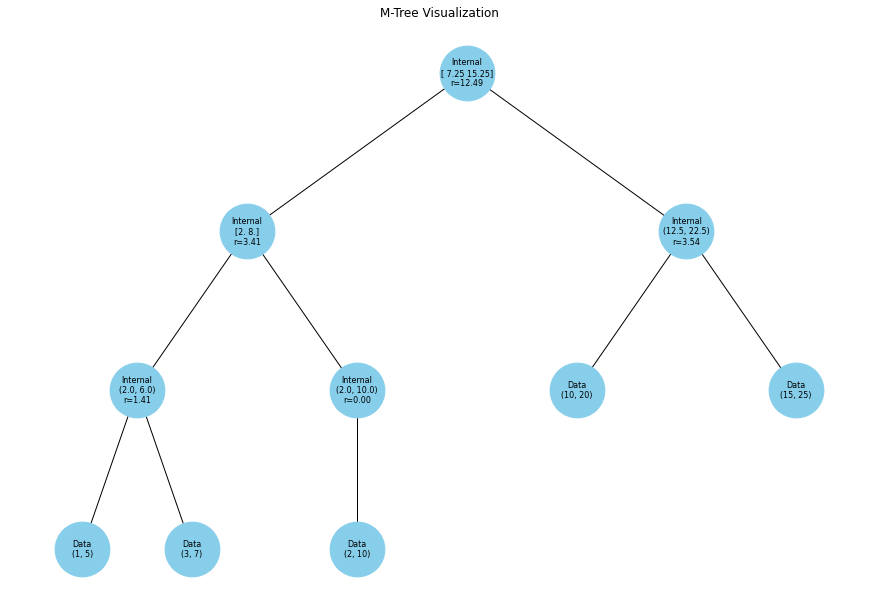

In [11]:
visualize_mtree_with_matplotlib(mtree)

In [12]:
print(mtree.root.children[1])

<(12.5, 22.5), r=3.5355339059327378, [DataNode(enty=(10, 20)), DataNode(enty=(15, 25))]>


In [ ]:

mtree.insert((2,11))


(7.25, 15.25)
(2.0, 8.0)


C:\Users\mahah\AppData\Local\Temp\ipykernel_15584\4034877277.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')


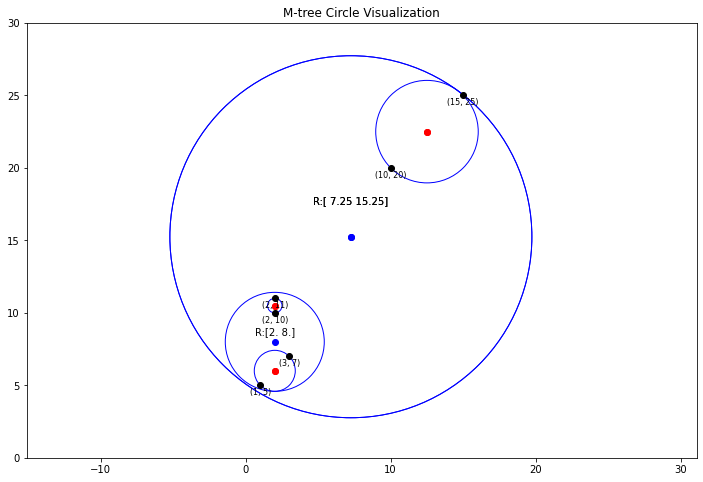

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_circle(ax, center, radius, color, label=None, linestyle='-'):
    """Plot a circle given its center and radius."""
    circle = plt.Circle(center, radius, color=color, fill=False, linestyle=linestyle)
    ax.add_artist(circle)
    if label:
        ax.text(center[0], center[1] + radius / 5, label, ha='center', va='center', fontsize=10)

def visualize_mtree(node, ax, x=0, y=0, offset=5, positions=None):
    """Visualize the M-tree with circles representing internal nodes and data points as leaves."""
    if positions is None:
        positions = []
        
    if node.is_leaf():
        # Plot the data points (leaf nodes)
        plot_circle(ax, (node.routing_object[0],node.routing_object[1]), node.covering_radius, color='blue')
        for data_node in node.children:
            point_x = data_node.value[0]  # Data value for x-coordinate
            point_y = data_node.value[1]  # All data points have y = 0
            ax.plot(point_x, point_y, 'ko')  # Black point for data node
            ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')
            ax.text(point_x, point_y - 0.5, f"{data_node.routing_object}", fontsize=8, ha='center', va='center')
            positions.append((point_x, point_y))
            
    else:
        # Plot internal node (routing object) as the center of the circle
        plot_circle(ax, (node.routing_object[0],node.routing_object[1]), node.covering_radius, color='blue', label=f"R:{node.routing_object}")
        print((node.routing_object[0], node.routing_object[1]))
        ax.plot(node.routing_object[0], node.routing_object[1], 'bo')  # Blue point for internal node

        # Recursively plot children (internal nodes or data nodes)
        for child in node.children:
            #print((child.routing_object[0], child.routing_object[1]))
            positions += visualize_mtree(child, ax, x=child.routing_object[0], y=child.routing_object[1], offset=offset)

    return positions

def plot_mtree_visualizations(mtree):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_aspect('equal', adjustable='datalim')

    # Visualize the circle representation (M-tree structure with circles)
    positions = []
    if mtree.root:
        # Plot the root node circle first
        root_x, root_y = mtree.root.routing_object[0], mtree.root.routing_object[1]
        plot_circle(ax, (root_x, root_y), mtree.root.covering_radius, color='blue', label=f"R:{mtree.root.routing_object}")
        ax.plot(root_x, root_y, 'bo')  # Blue point for the root node
        positions.append((root_x, root_y))
        positions = visualize_mtree(mtree.root, ax)
    
    # Calculate bounds for x and y axes to ensure everything fits
    x_vals, y_vals = zip(*positions)
    ax.set_xlim(min(x_vals) - 5, max(x_vals) + 5)  # Adding margin for clarity
    ax.set_ylim(min(y_vals) - 5, max(y_vals) + 5)
    
    ax.set_title("M-tree Circle Visualization")
    plt.show()

plot_mtree_visualizations(mtree)


In [15]:
print(mtree)

<array([ 7.25, 15.25]), r=12.486790800916816, [<array([2., 8.]), r=3.414213562373095, [<(2.0, 6.0), r=1.4142135623730951, [DataNode(enty=(1, 5)), DataNode(enty=(3, 7))]>, <array([ 2. , 10.5]), r=0.5, [DataNode(enty=(2, 10)), DataNode(enty=(2, 11))]>]>, <(12.5, 22.5), r=3.5355339059327378, [DataNode(enty=(10, 20)), DataNode(enty=(15, 25))]>]>


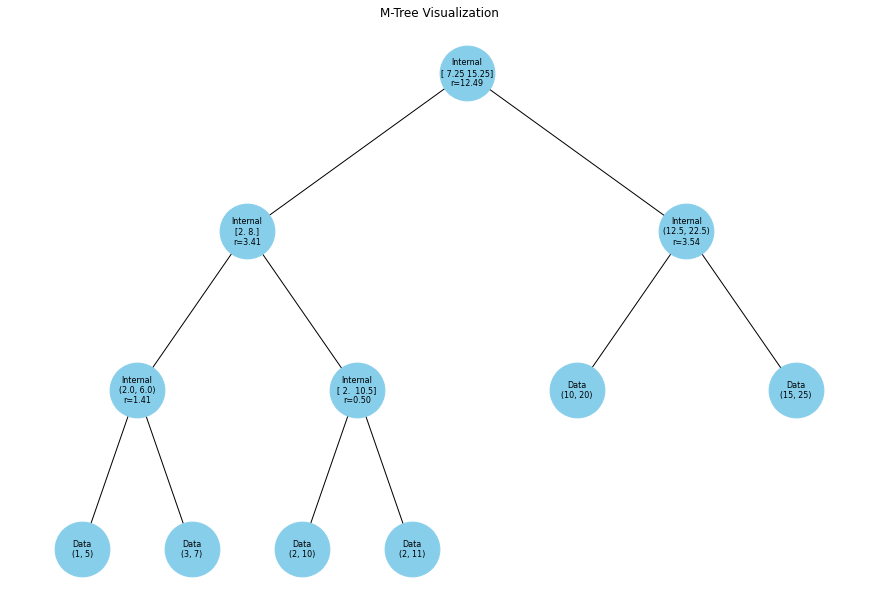

In [16]:
visualize_mtree_with_matplotlib(mtree)

In [17]:
print(mtree)

<array([ 7.25, 15.25]), r=12.486790800916816, [<array([2., 8.]), r=3.414213562373095, [<(2.0, 6.0), r=1.4142135623730951, [DataNode(enty=(1, 5)), DataNode(enty=(3, 7))]>, <array([ 2. , 10.5]), r=0.5, [DataNode(enty=(2, 10)), DataNode(enty=(2, 11))]>]>, <(12.5, 22.5), r=3.5355339059327378, [DataNode(enty=(10, 20)), DataNode(enty=(15, 25))]>]>


In [ ]:
mtree.insert((11,21))

In [19]:
print(mtree.root)

<array([ 7.375, 15.375]), r=13.014943420748, [<array([2., 8.]), r=3.414213562373095, [<(2.0, 6.0), r=1.4142135623730951, [DataNode(enty=(1, 5)), DataNode(enty=(3, 7))]>, <array([ 2. , 10.5]), r=0.5, [DataNode(enty=(2, 10)), DataNode(enty=(2, 11))]>]>, <array([12.75, 22.75]), r=3.8890872965260113, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 25.]), r=0.0, [DataNode(enty=(15, 25))]>]>]>


(7.375, 15.375)
(2.0, 8.0)
(12.75, 22.75)


C:\Users\mahah\AppData\Local\Temp\ipykernel_15584\4034877277.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')


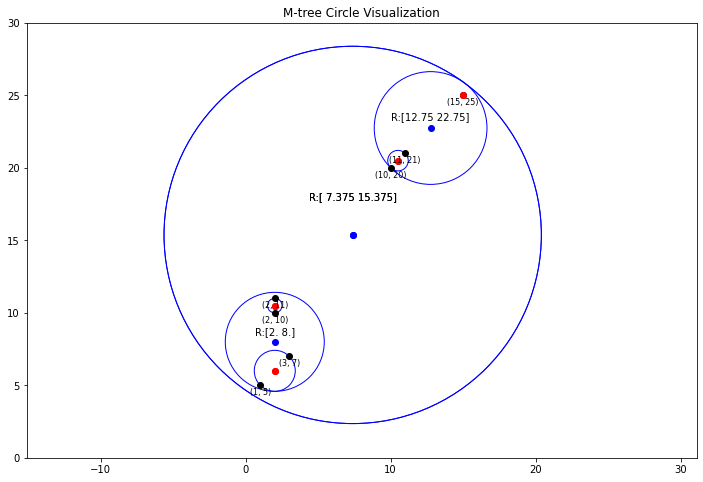

In [20]:
plot_mtree_visualizations(mtree)

In [21]:
print(mtree)

<array([ 7.375, 15.375]), r=13.014943420748, [<array([2., 8.]), r=3.414213562373095, [<(2.0, 6.0), r=1.4142135623730951, [DataNode(enty=(1, 5)), DataNode(enty=(3, 7))]>, <array([ 2. , 10.5]), r=0.5, [DataNode(enty=(2, 10)), DataNode(enty=(2, 11))]>]>, <array([12.75, 22.75]), r=3.8890872965260113, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 25.]), r=0.0, [DataNode(enty=(15, 25))]>]>]>


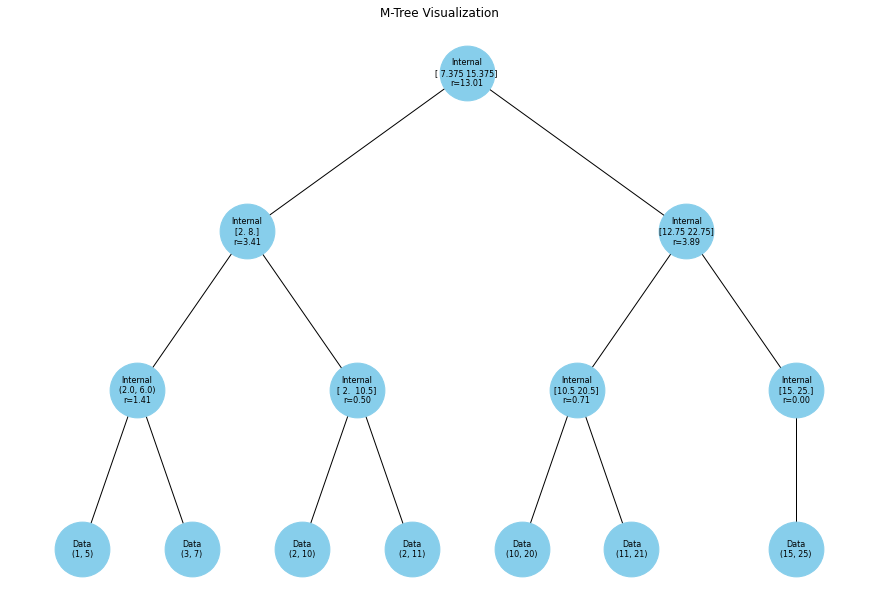

In [22]:
visualize_mtree_with_matplotlib(mtree)

(7.375, 15.375)
(2.0, 8.0)
(12.75, 22.75)


C:\Users\mahah\AppData\Local\Temp\ipykernel_15584\4034877277.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')


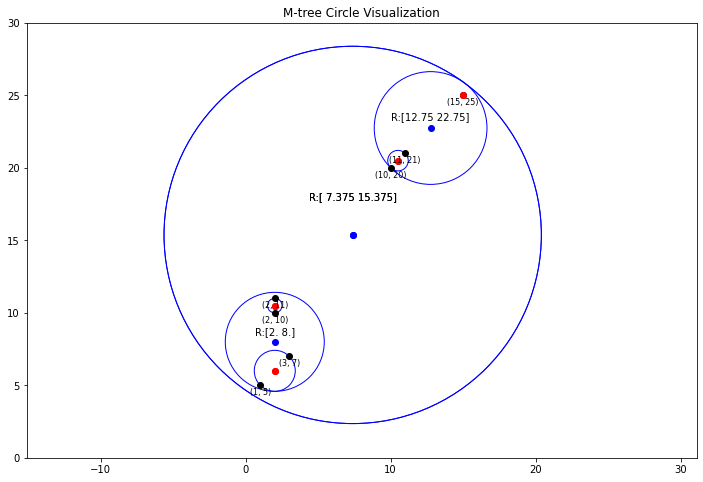

In [23]:
plot_mtree_visualizations(mtree)

In [24]:
print(mtree)

<array([ 7.375, 15.375]), r=13.014943420748, [<array([2., 8.]), r=3.414213562373095, [<(2.0, 6.0), r=1.4142135623730951, [DataNode(enty=(1, 5)), DataNode(enty=(3, 7))]>, <array([ 2. , 10.5]), r=0.5, [DataNode(enty=(2, 10)), DataNode(enty=(2, 11))]>]>, <array([12.75, 22.75]), r=3.8890872965260113, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 25.]), r=0.0, [DataNode(enty=(15, 25))]>]>]>


In [ ]:
mtree.insert((2,4))

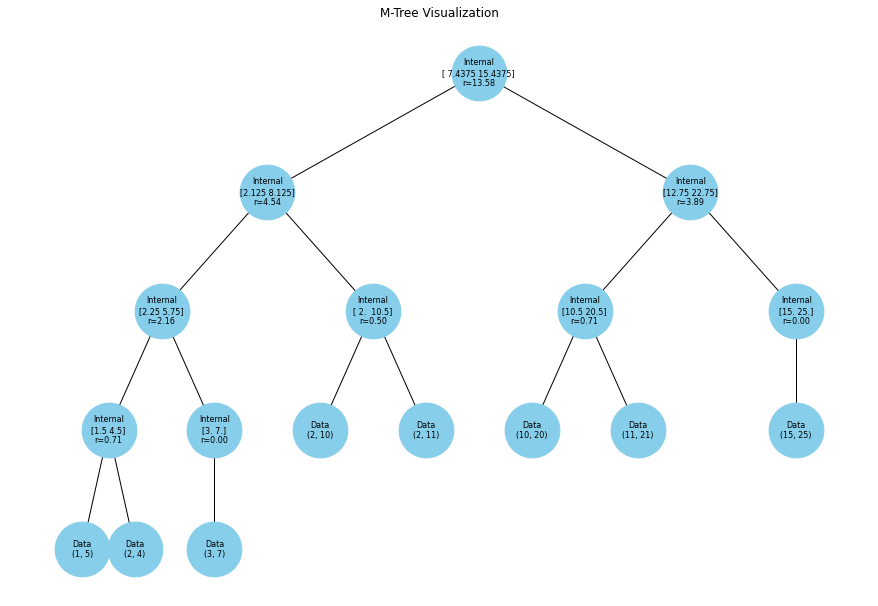

In [26]:
visualize_mtree_with_matplotlib(mtree)

(7.4375, 15.4375)
(2.125, 8.125)
(2.25, 5.75)
(12.75, 22.75)


C:\Users\mahah\AppData\Local\Temp\ipykernel_15584\4034877277.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')


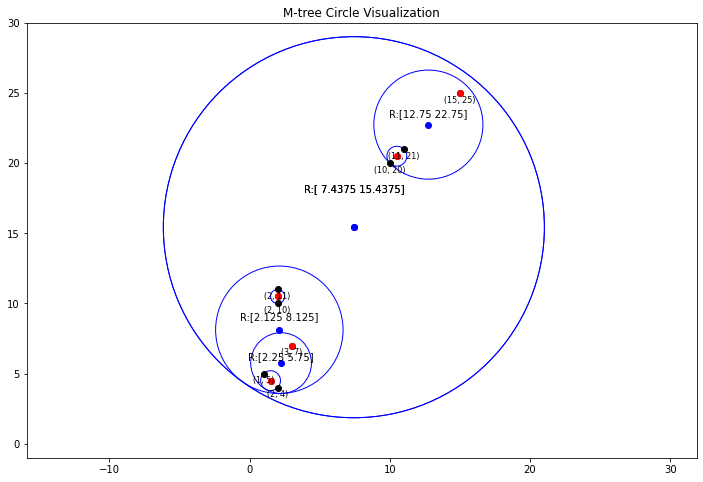

In [27]:
plot_mtree_visualizations(mtree)

In [ ]:
mtree.insert((15,27))

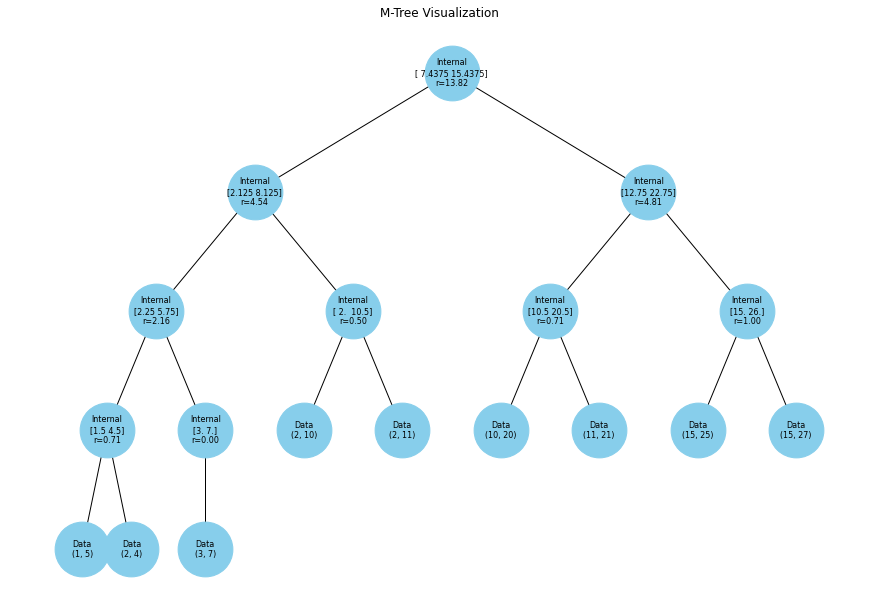

In [29]:
visualize_mtree_with_matplotlib(mtree)

(7.4375, 15.4375)
(2.125, 8.125)
(2.25, 5.75)
(12.75, 22.75)


C:\Users\mahah\AppData\Local\Temp\ipykernel_15584\4034877277.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(node.routing_object[0], node.routing_object[1], 'ko',color='red')


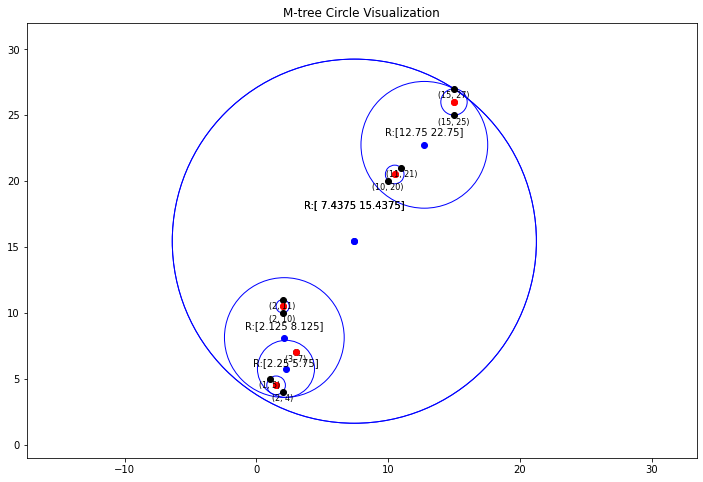

In [30]:
plot_mtree_visualizations(mtree)

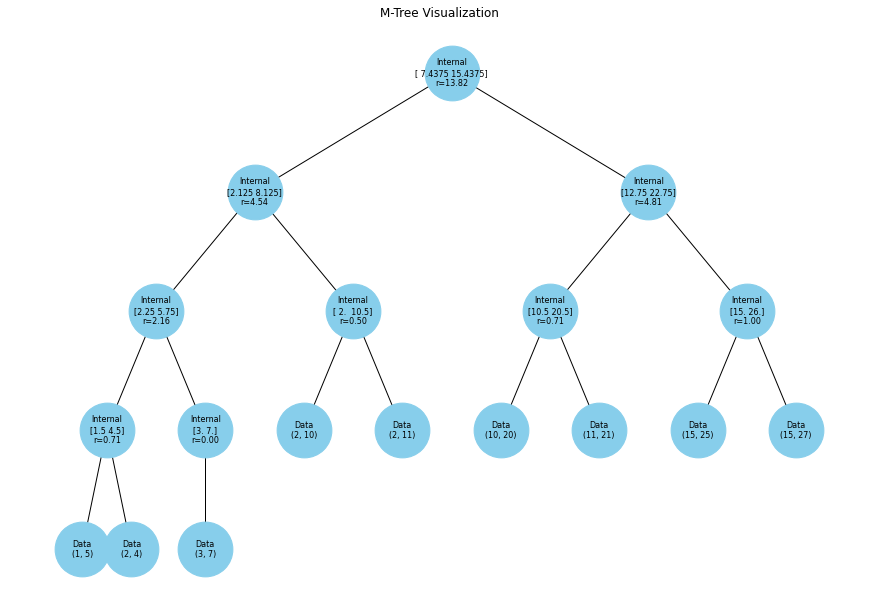

In [31]:
visualize_mtree_with_matplotlib(mtree)

In [ ]:
mtree.insert((2,12))

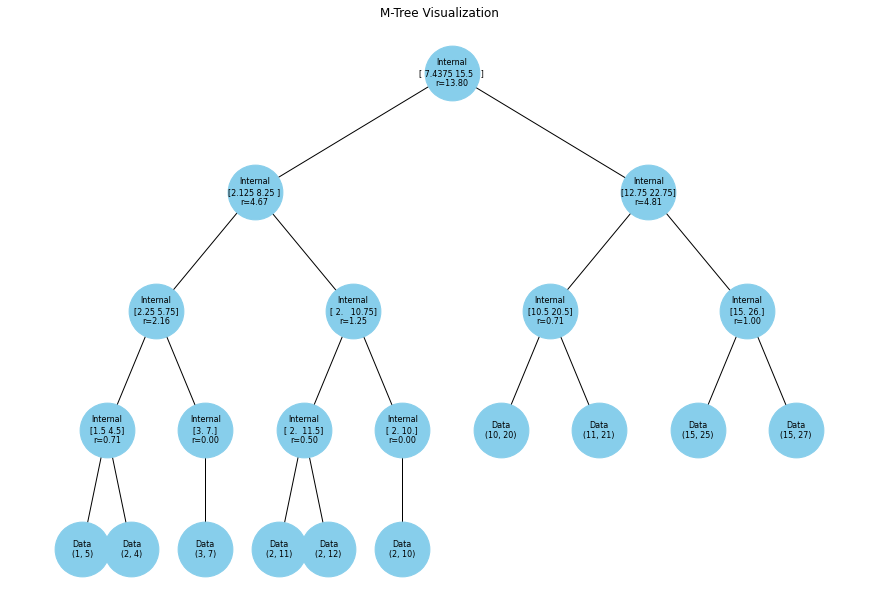

In [33]:
visualize_mtree_with_matplotlib(mtree)

In [34]:
print(mtree)

<array([ 7.4375, 15.5   ]), r=13.79690232643414, [<array([2.125, 8.25 ]), r=4.6679678042104715, [<array([2.25, 5.75]), r=2.1648447548978726, [<array([1.5, 4.5]), r=0.7071067811865476, [DataNode(enty=(1, 5)), DataNode(enty=(2, 4))]>, <array([3., 7.]), r=0.0, [DataNode(enty=(3, 7))]>]>, <array([ 2.  , 10.75]), r=1.25, [<array([ 2. , 11.5]), r=0.5, [DataNode(enty=(2, 11)), DataNode(enty=(2, 12))]>, <array([ 2., 10.]), r=0.0, [DataNode(enty=(2, 10))]>]>]>, <array([12.75, 22.75]), r=4.808846015417836, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 26.]), r=1.0, [DataNode(enty=(15, 25)), DataNode(enty=(15, 27))]>]>]>


In [35]:
query_point = (15,27)
k = 2
neighbors = mtree.knn(query_point, k)

    # Print results
print(f"Query Point: {query_point}")
print(f"{k} Nearest Neighbors: {neighbors}")

Query Point: (15, 27)
2 Nearest Neighbors: [(15, 27), (15, 25)]


In [36]:
print(mtree)

<array([ 7.4375, 15.5   ]), r=13.79690232643414, [<array([2.125, 8.25 ]), r=4.6679678042104715, [<array([2.25, 5.75]), r=2.1648447548978726, [<array([1.5, 4.5]), r=0.7071067811865476, [DataNode(enty=(1, 5)), DataNode(enty=(2, 4))]>, <array([3., 7.]), r=0.0, [DataNode(enty=(3, 7))]>]>, <array([ 2.  , 10.75]), r=1.25, [<array([ 2. , 11.5]), r=0.5, [DataNode(enty=(2, 11)), DataNode(enty=(2, 12))]>, <array([ 2., 10.]), r=0.0, [DataNode(enty=(2, 10))]>]>]>, <array([12.75, 22.75]), r=4.808846015417836, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 26.]), r=1.0, [DataNode(enty=(15, 25)), DataNode(enty=(15, 27))]>]>]>


In [37]:
print(mtree.root.covering_radius)

13.79690232643414


In [38]:
print(mtree)

<array([ 7.4375, 15.5   ]), r=13.79690232643414, [<array([2.125, 8.25 ]), r=4.6679678042104715, [<array([2.25, 5.75]), r=2.1648447548978726, [<array([1.5, 4.5]), r=0.7071067811865476, [DataNode(enty=(1, 5)), DataNode(enty=(2, 4))]>, <array([3., 7.]), r=0.0, [DataNode(enty=(3, 7))]>]>, <array([ 2.  , 10.75]), r=1.25, [<array([ 2. , 11.5]), r=0.5, [DataNode(enty=(2, 11)), DataNode(enty=(2, 12))]>, <array([ 2., 10.]), r=0.0, [DataNode(enty=(2, 10))]>]>]>, <array([12.75, 22.75]), r=4.808846015417836, [<array([10.5, 20.5]), r=0.7071067811865476, [DataNode(enty=(10, 20)), DataNode(enty=(11, 21))]>, <array([15., 26.]), r=1.0, [DataNode(enty=(15, 25)), DataNode(enty=(15, 27))]>]>]>
